In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Data augmentation for training
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

# No augmentation for validation / test
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

# Load datasets
train_dataset = datasets.ImageFolder(root = "/content/data/train",transform=train_transforms)

val_dataset = datasets.ImageFolder("/content/data/train",transform=val_transforms)

test_dataset = datasets.ImageFolder("/content/data/train",transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)

val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 4000
Validation samples: 4000
Test samples: 4000


***MODEL SETUP***

In [4]:
# Load pretrained ResNet18
model = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Move to device (CUDA if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Using device: {device}")
print(f"Training only final layer with {model.fc.in_features} input features to 2 outputs")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


Using device: cuda
Training only final layer with 512 input features to 2 outputs


***TRAINING SETUP***

In [5]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=3,
    factor=0.5
)

# Training tracking
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_acc = 0.0


***Unfreezing some layers***

In [6]:
# Unfreeze last residual block
for param in model.layer4.parameters():
    param.requires_grad = True

# Fine-tune with lower learning rates
optimizer = optim.Adam(
    [
        {"params": model.layer4.parameters(), "lr": 0.0001},
        {"params": model.fc.parameters(), "lr": 0.001},
    ]
)

***TRAINING LOOP***

In [7]:
num_epochs = 10

for epoch in range(num_epochs):

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Update learning rate
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Saved best model with val_acc: {val_acc:.2f}%")

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print()


Saved best model with val_acc: 97.78%
Epoch [1/10]
Train Loss: 0.1406, Train Acc: 94.20%
Val Loss: 0.0597, Val Acc: 97.78%

Saved best model with val_acc: 99.12%
Epoch [2/10]
Train Loss: 0.0875, Train Acc: 96.58%
Val Loss: 0.0244, Val Acc: 99.12%

Saved best model with val_acc: 99.58%
Epoch [3/10]
Train Loss: 0.0636, Train Acc: 97.67%
Val Loss: 0.0137, Val Acc: 99.58%

Saved best model with val_acc: 99.75%
Epoch [4/10]
Train Loss: 0.0584, Train Acc: 97.83%
Val Loss: 0.0093, Val Acc: 99.75%

Epoch [5/10]
Train Loss: 0.0521, Train Acc: 98.08%
Val Loss: 0.0195, Val Acc: 99.30%

Saved best model with val_acc: 99.83%
Epoch [6/10]
Train Loss: 0.0510, Train Acc: 98.20%
Val Loss: 0.0085, Val Acc: 99.83%

Epoch [7/10]
Train Loss: 0.0407, Train Acc: 98.35%
Val Loss: 0.0119, Val Acc: 99.58%

Epoch [8/10]
Train Loss: 0.0377, Train Acc: 98.53%
Val Loss: 0.0054, Val Acc: 99.83%

Epoch [9/10]
Train Loss: 0.0462, Train Acc: 98.12%
Val Loss: 0.0065, Val Acc: 99.75%

Saved best model with val_acc: 99.85

**Evaluation on test Set**

In [10]:
# Load best model
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100.0 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 99.85%


***VISUALIZATION***

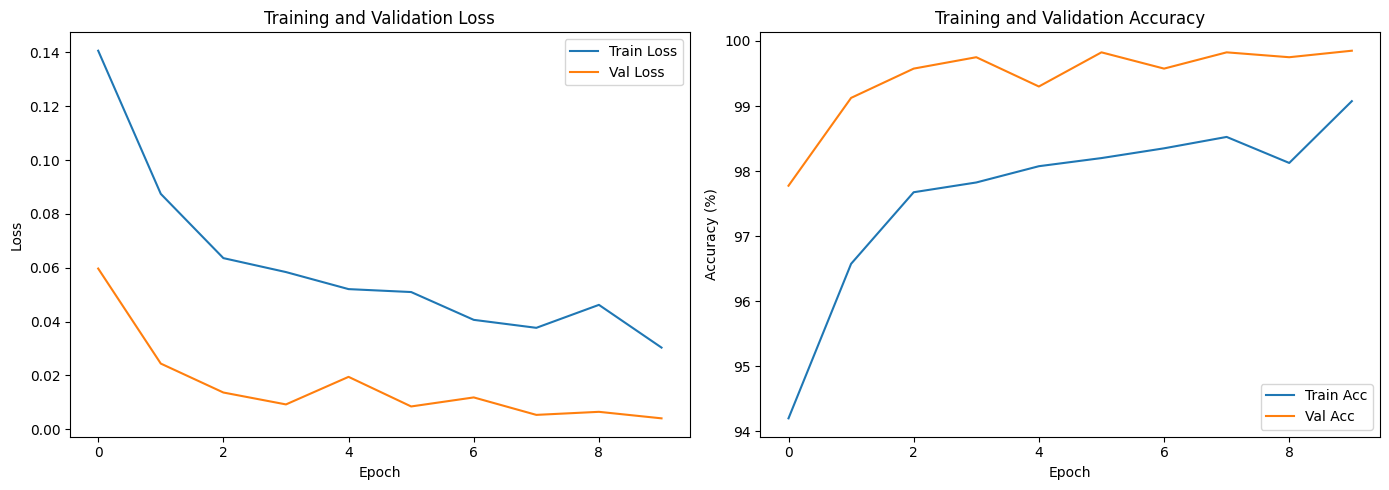

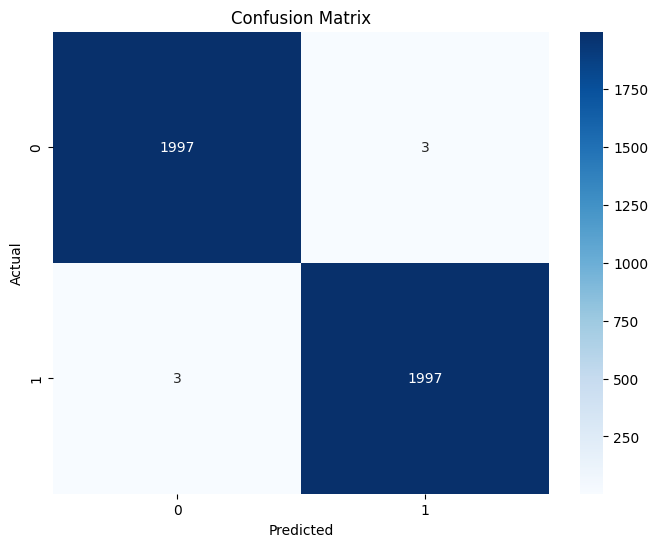

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1.plot(train_losses, label="Train Loss")
ax1.plot(val_losses, label="Val Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()

# Accuracy curves
ax2.plot(train_accs, label="Train Acc")
ax2.plot(val_accs, label="Val Acc")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()


# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()


**Visualizing Predictions / TESTING**

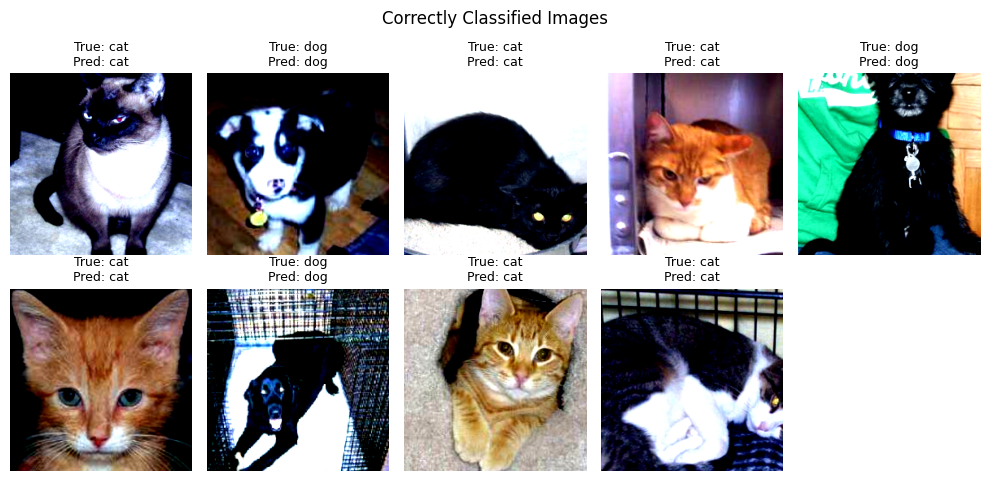

<Figure size 1000x500 with 0 Axes>

In [18]:
import torch
model.eval()
classes = ('cat','dog')
num_of_images = 0

correct = []
incorrect = []

dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images[:10]
labels = labels[:10]

images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)
for i in range(len(images)):
    num_of_images += 1
    if predicted[i] == labels[i] and num_of_images < 10:
        correct.append(i)
    elif predicted[i] != labels[i] and num_of_images < 10:
        incorrect.append(i)

    if num_of_images == 10:
        num_of_images = 0
        break


def show_predictions(images, labels, predicted, classes, title):
    images = images / 2 + 0.5  # un-normalize
    np_images = images.cpu().numpy()

    plt.figure(figsize=(10, 5))
    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(np_images[i], (1, 2, 0)))
        plt.title(
            f"True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}",
            fontsize=9
        )
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Correctly classified
show_predictions(
    images[correct],
    labels[correct],
    predicted[correct],
    classes,
    title="Correctly Classified Images"
)

# Incorrectly classified
show_predictions(
    images[incorrect],
    labels[incorrect],
    predicted[incorrect],
    classes,
    title="Incorrectly Classified Images"
)
